I have always wanted to write a ufunc function in Python.  With Numba, you can --- and it will be fast.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from numba import jit
import math

Define some polynomial evaluation tools.

In [3]:
@jit('f8(f8,f8[:])', nopython=True)
def polevl(x, coef):
    N = len(coef)
    ans = coef[0]
    i = 1
    while i < N:
        ans = ans * x + coef[i]
        i += 1
    return ans

@jit('f8(f8,f8[:])', nopython=True)
def p1evl(x, coef):
    N = len(coef)
    ans = x + coef[0]
    i = 1
    while i < N:
        ans = ans * x + coef[i]
        i += 1
    return ans    


Define some constants!

In [4]:
PP = np.array([
  7.96936729297347051624E-4,
  8.28352392107440799803E-2,
  1.23953371646414299388E0,
  5.44725003058768775090E0,
  8.74716500199817011941E0,
  5.30324038235394892183E0,
  9.99999999999999997821E-1], 'd')

PQ = np.array([
  9.24408810558863637013E-4,
  8.56288474354474431428E-2,
  1.25352743901058953537E0,
  5.47097740330417105182E0,
  8.76190883237069594232E0,
  5.30605288235394617618E0,
  1.00000000000000000218E0], 'd')
  
DR1 = 5.783185962946784521175995758455807035071
DR2 = 30.47126234366208639907816317502275584842

RP = np.array([
-4.79443220978201773821E9,
 1.95617491946556577543E12,
-2.49248344360967716204E14,
 9.70862251047306323952E15], 'd')

RQ = np.array([
    # 1.00000000000000000000E0,
 4.99563147152651017219E2,
 1.73785401676374683123E5,
 4.84409658339962045305E7,
 1.11855537045356834862E10,
 2.11277520115489217587E12,
 3.10518229857422583814E14,
 3.18121955943204943306E16,
 1.71086294081043136091E18], 'd')

QP = np.array([
-1.13663838898469149931E-2,
-1.28252718670509318512E0,
-1.95539544257735972385E1,
-9.32060152123768231369E1,
-1.77681167980488050595E2,
-1.47077505154951170175E2,
-5.14105326766599330220E1,
-6.05014350600728481186E0], 'd')

QQ = np.array([
    # 1.00000000000000000000E0,
  6.43178256118178023184E1,
  8.56430025976980587198E2,
  3.88240183605401609683E3,
  7.24046774195652478189E3,
  5.93072701187316984827E3,
  2.06209331660327847417E3,
  2.42005740240291393179E2], 'd')

NPY_PI_4 = .78539816339744830962
SQ2OPI  = .79788456080286535587989


Now for the function itself

In [5]:
@jit('f8(f8)')
def j0(x):
    if (x < 0):
        x = -x

    if (x <= 5.0):
        z = x * x
        if (x < 1.0e-5):
            return (1.0 - z / 4.0)
        p = (z-DR1) * (z-DR2)
        p = p * polevl(z, RP) / polevl(z, RQ)
        return p
    
    w = 5.0 / x
    q = 25.0 / (x*x)
    p = polevl(q, PP) / polevl(q, PQ)
    q = polevl(q, QP) / p1evl(q, QQ)
    xn = x - NPY_PI_4
    p = p*math.cos(xn) - w * q * math.sin(xn)
    return p * SQ2OPI / math.sqrt(x)


In [6]:
from numba import vectorize
import scipy.special as ss

vj0 = vectorize(['f8(f8)'])(j0.py_func)


In [7]:
x = np.linspace(-10,10,1000)

In [8]:
%timeit vj0(x)

100 loops, best of 3: 4.47 ms per loop


In [9]:
%timeit ss.j0(x)

The slowest run took 11.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 28.4 µs per loop


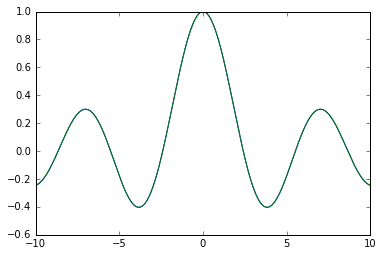

In [10]:
plot(x, vj0(x), x, ss.j0(x))

This was run on a Macbook Air.   Running `sysctl -n machdep.cpu.brand_string` resulted in:

  Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz